In this notebook we investigate the transitions that a crystal of ultra-cold ions in a Penning trap undergoes as the rotation frequency of the ions in the trap is increased. As the rotation frequency increases, the radial confinement becomes stronger. Eventually it becomes energetically favourable, to stack several crystal of ions on top of one another. The frequencies at which these transitions occur are well understood theoretically and serve as a verification of the numerical integration of the ions motion.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.lines
import numpy as np
import mode_analysis_code
import coldatoms
import ion_trapping

First we need to find an initial configuration of the ions close to their ground state

In [2]:
mode_analysis = mode_analysis_code.ModeAnalysis(N=127,
                                                Vtrap=(0.0, -1750.0, -1970.0),
                                                Vwall=1.0,
                                                frot=185.0)

In [3]:
mode_analysis.run()

In [4]:
mode_analysis.show_axial_Evals();

<IPython.core.display.Javascript object>

In [5]:
def create_ensemble(uE, omega_z, mass, charge):
    num_ions = int(uE.size / 2)
    x = uE[:num_ions]
    y = uE[num_ions:]
    r = np.sqrt(x**2 + y**2)
    r_hat = np.transpose(np.array([x / r, y / r]))
    phi_hat = np.transpose(np.array([-y / r, x / r]))
    v = np.zeros([num_ions, 2], dtype=np.float64)
    for i in range(num_ions):
        v[i, 0] = omega_z * r[i] * phi_hat[i, 0]
        v[i, 1] = omega_z * r[i] * phi_hat[i, 1]
    
    ensemble = coldatoms.Ensemble(num_ions)
    for i in range(num_ions):
        ensemble.x[i, 0] = x[i]
        ensemble.x[i, 1] = y[i]
        ensemble.x[i, 2] = 0.0
        ensemble.v[i, 0] = v[i, 0]
        ensemble.v[i, 1] = v[i, 1]
        ensemble.v[i, 2] = 0.0
    
    ensemble.ensemble_properties['mass'] = mass
    ensemble.ensemble_properties['charge'] = charge
    
    return ensemble

# Forces

In [6]:
coulomb_force = coldatoms.CoulombForce()

class TrapPotential(object):

    def __init__(self, kz, delta, omega, phi_0):
        self.kz = kz
        self.kx = -(0.5 + delta) * kz
        self.ky = -(0.5 - delta) * kz
        self.phi_0 = phi_0
        self.phi = phi_0
        self.omega = omega
        self.trap_potential = coldatoms.HarmonicTrapPotential(self.kx, self.ky, self.kz)

    def reset_phase(self):
        self.phi = self.phi_0
            
    def force(self, dt, ensemble, f):
        self.phi += self.omega * 0.5 * dt
        self.trap_potential.phi = self.phi
        self.trap_potential.force(dt, ensemble, f)
        self.phi += self.omega * 0.5 * dt

trap_potential = TrapPotential(2.0 * mode_analysis.Coeff[2], mode_analysis.Cw, mode_analysis.wrot, np.pi / 2.0)

After we change the rotation frequency we need the ions to settle into a new steady state. This requires a damping of the azimuthal motion of the ions. In the rotating frame, the ions should settle to a state where they co-rotate with the trap at the new frequency.

In [7]:
class AngularDamping(object):

    def __init__(self, omega, kappa_theta):
        self.omega = omega
        self.kappa_theta = kappa_theta
            
    def dampen(self, dt, ensemble):
        ion_trapping.angular_damping(self.omega, self.kappa_theta * dt, ensemble.x, ensemble.v)

In [8]:
class AxialDamping(object):
    """Doppler cooling along z without recoil."""

    def __init__(self, kappa):
        """kappa is the damping rate."""
        self.kappa = kappa
            
    def dampen(self, dt, ensemble):
        ion_trapping.axial_damping(self.kappa * dt, ensemble.v)

In [9]:
def evolve_ensemble_with_damping(dt, t_max, ensemble, Bz, forces, dampings):
    num_steps = int(np.floor(t_max / dt))
    for i in range(num_steps):
        coldatoms.bend_kick(dt, Bz, ensemble, forces, num_steps=1)
        for d in dampings:
            d.dampen(dt, ensemble)
    fractional_dt = t_max - (num_steps * dt)
    if (fractional_dt / dt > 1.0e-6):
        coldatoms.bend_kick(fractional_dt, Bz, ensemble, forces, num_steps=1)
        for d in dampings:
            d.dampen(fractional_dt, ensemble)

In [10]:
def radius(x):
    return np.sqrt(x[:, 0]**2 + x[:, 1]**2)

def speed(v):
    return np.sqrt(v[:, 0]**2 + v[:, 1]**2 + v[:, 2]**2)

def radial_velocity(x, v):
    num_ptcls = v.shape[0]
    velocity = np.zeros(num_ptcls)
    for i in range(num_ptcls):
        r_hat = np.copy(x[i, :2])
        r_hat /= np.linalg.norm(r_hat)
        velocity[i] = r_hat.dot(v[i, :2])
    return velocity

def angular_velocity(x, v):
    num_ptcls = v.shape[0]
    velocity = np.zeros(num_ptcls)
    for i in range(num_ptcls):
        r_hat = np.copy(x[i, :2])
        r_hat /= np.linalg.norm(r_hat)
        v_r = r_hat * (r_hat.dot(v[i, :2]))
        velocity[i] = np.linalg.norm(v[i, :2] - v_r)
    return velocity

In [11]:
def evolve_to_steady_state(dt=1.0e-9, t_max=1.0e-8, dampings=[],
                           omega=2.0 * np.pi * 180.0e3, vz_perturbation=1.0e-3):
    my_ensemble = create_ensemble(mode_analysis.uE,
                                  omega,
                                  mode_analysis.m_Be,
                                  mode_analysis.q)
    my_ensemble.v[:, 2] += np.random.normal(loc=0.0, scale=vz_perturbation, size=my_ensemble.num_ptcls)

    x_0 = np.copy(my_ensemble.x)
    v_0 = np.copy(my_ensemble.v)
    
    trap_potential.phi = np.pi / 2.0
    trap_potential.omega = omega

    evolve_ensemble_with_damping(
        dt,
        t_max,
        my_ensemble,
        mode_analysis.B,
        [coulomb_force, trap_potential],
        dampings)
    
    return (my_ensemble, x_0, v_0)

In [12]:
omega = 1.2 * mode_analysis.wrot
t_max = 2.0e1 * 2.0 * np.pi / omega
dt=1.0e-9
print(t_max)
kappa = 1.0e7
my_ensemble, x0, v0 = evolve_to_steady_state(t_max=t_max, dt=dt, omega=omega,
                                             dampings=[AngularDamping(omega, kappa)]);


9.00900900900901e-05


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


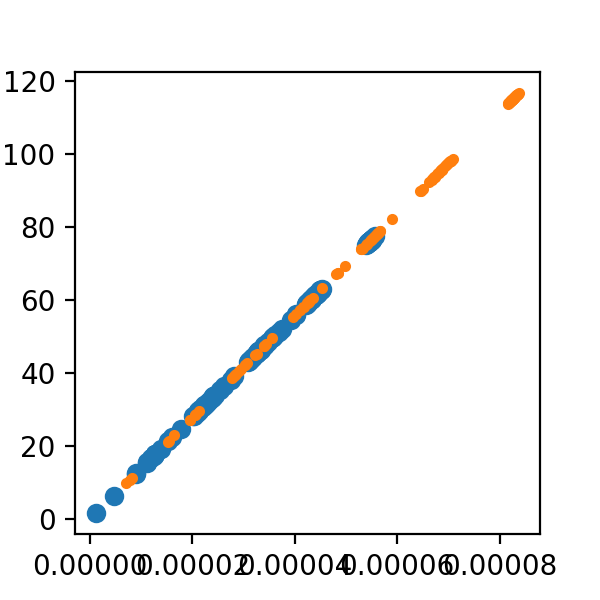

In [14]:
plt.figure(figsize=(3,3))
plt.plot(radius(my_ensemble.x), angular_velocity(my_ensemble.x, my_ensemble.v), 'o')
plt.plot(radius(x0), omega * radius(x0), '.')

<IPython.core.display.Javascript object>


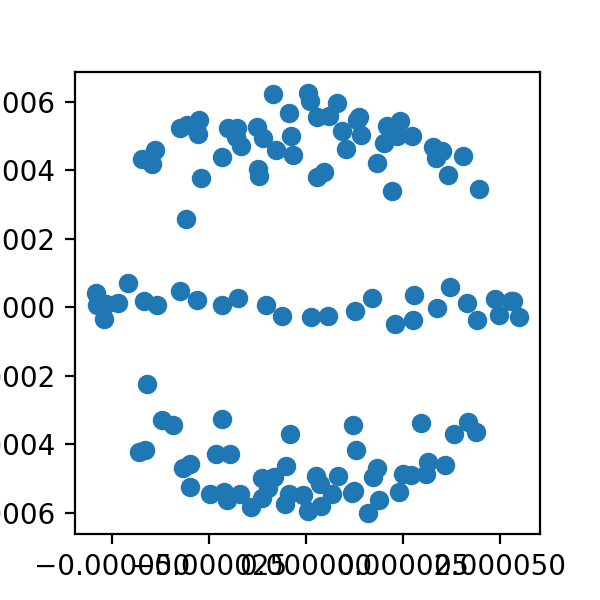

In [15]:
plt.figure(figsize=(3,3))
plt.plot(my_ensemble.x[:,0], my_ensemble.x[:,2], 'o')


In [16]:
np.std(my_ensemble.x[:,2])

4.2312516732229102e-06

In [17]:
w = mode_analysis.wrot
omegas = np.linspace(0.9 * w, 3.0 * w, 100)
thicknesses = []
for omega in omegas:
    t_max = 16.0e0 * 2.0 * np.pi / omega
    dt=1.0e-9
    kappa = 5.0e6
    my_ensemble, x0, v0 = evolve_to_steady_state(t_max=t_max, dt=dt, omega=omega,
                                             dampings=[AngularDamping(omega, kappa), AxialDamping(0.1 * kappa)])
    thickness = np.std(my_ensemble.x[:,2])
    print(omega, thickness)
    thicknesses.append(thickness)
thicknesses = np.array(thicknesses)
print(omegas)
print(thicknesses)

1046150.35365 2.95687222445e-21
1070807.09599 5.70295852013e-21
1095463.83833 9.2616602248e-21
1120120.58067 1.81317436151e-20
1144777.32301 2.75528290684e-20
1169434.06535 5.17005775807e-20
1194090.8077 7.88237042644e-20
1218747.55004 1.20849503314e-06
1243404.29238 1.94224742617e-06
1268061.03472 2.48587582179e-06
1292717.77706 2.93539056608e-06
1317374.51941 3.31713106219e-06
1342031.26175 3.65531782428e-06
1366688.00409 3.95851095976e-06
1391344.74643 4.18664988712e-06
1416001.48877 4.41496474541e-06
1440658.23111 4.64804980802e-06
1465314.97346 4.87883058812e-06
1489971.7158 5.11893800404e-06
1514628.45814 5.33421022896e-06
1539285.20048 5.53905814574e-06
1563941.94282 5.72103249714e-06
1588598.68517 5.93135202303e-06
1613255.42751 6.12861567348e-06
1637912.16985 6.27090149693e-06
1662568.91219 6.43685193386e-06
1687225.65453 6.58863513077e-06
1711882.39687 6.73067672601e-06
1736539.13922 6.89270812851e-06
1761195.88156 7.03753743956e-06
1785852.6239 7.1804913487e-06
1810509.36624

In [18]:
omegas = np.linspace(0.9 * w, 3.0 * w, 100)

<IPython.core.display.Javascript object>


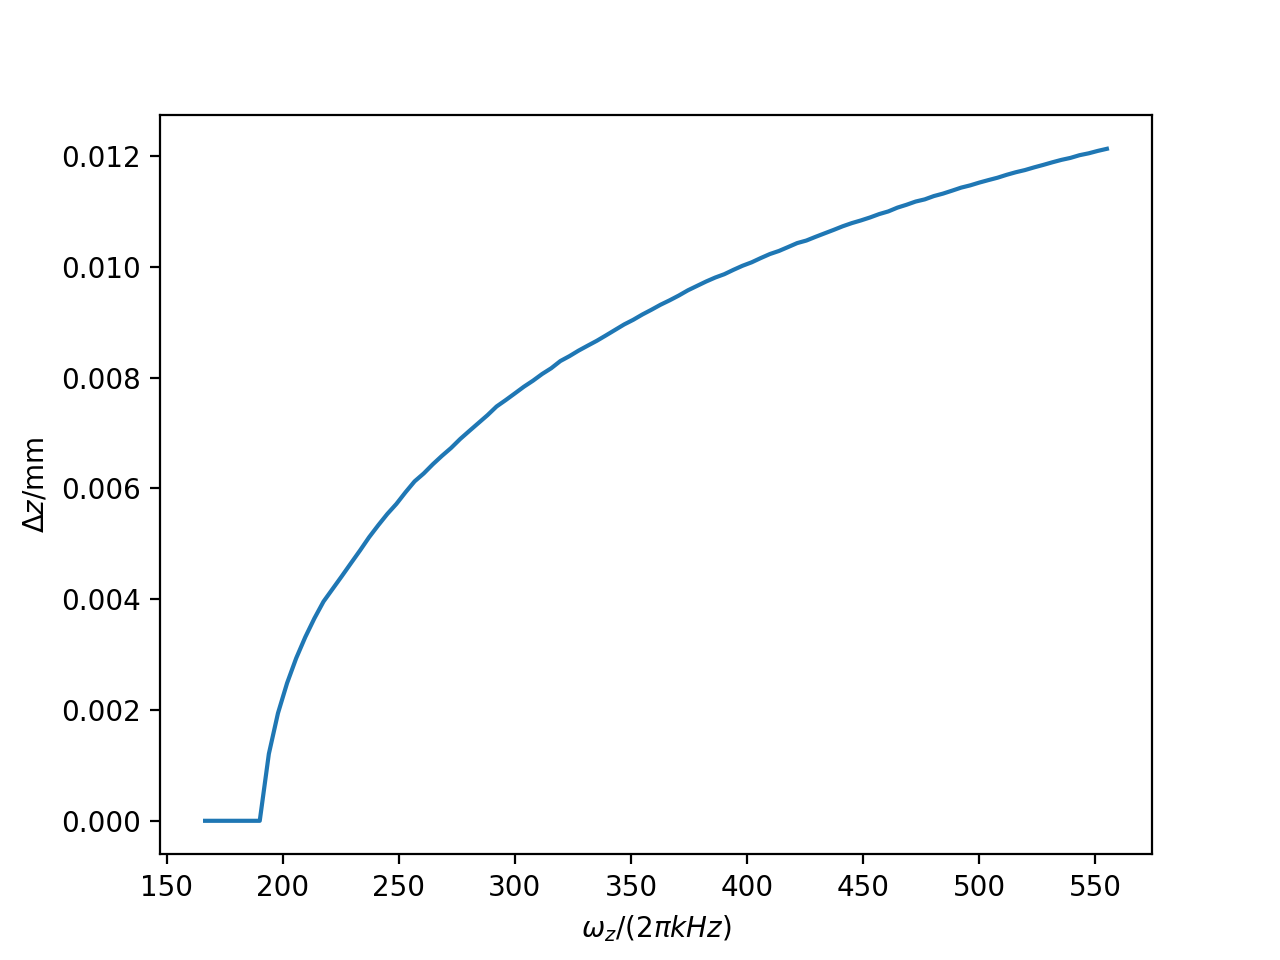

In [19]:
plt.figure()
plt.plot(omegas/(2.0*np.pi*1.0e3), thicknesses*1.0e3)
plt.xlabel(r'$\omega_z/(2\pi kHz)$')
plt.ylabel(r'$\Delta z/{\rm mm}$')

<IPython.core.display.Javascript object>


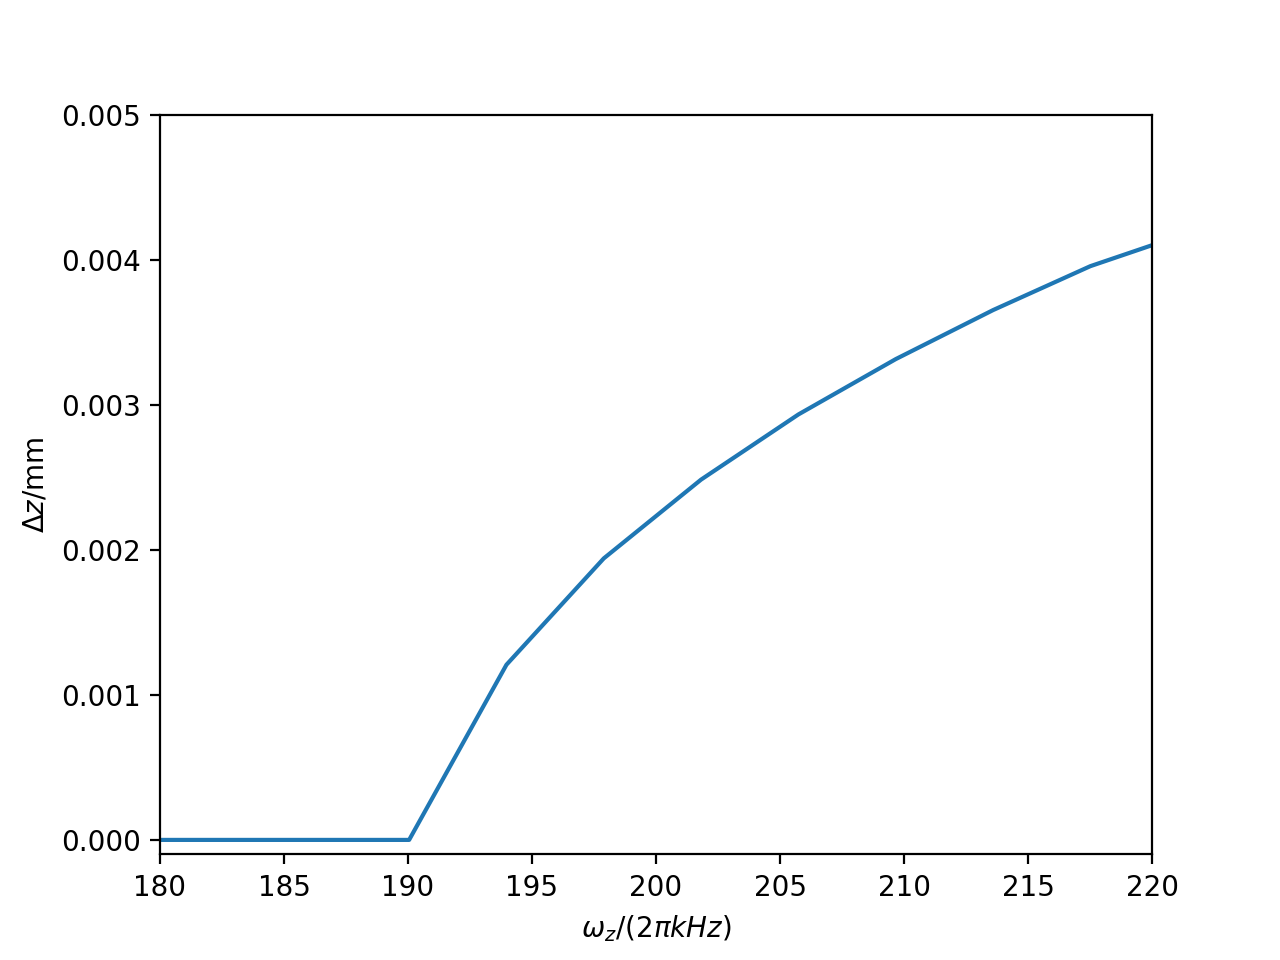

In [20]:
plt.figure()
plt.plot(omegas/(2.0*np.pi*1.0e3), thicknesses*1.0e3)
plt.xlim([180, 220])
plt.ylim([-1.0e-4,5.0e-3])
plt.xlabel(r'$\omega_z/(2\pi kHz)$')
plt.ylabel(r'$\Delta z/{\rm mm}$')

# Frequency sweeps

Now we want to simulate sweeps of the rotation frequency. We assume that the frequency varies piecewise linearly, i.e. with a constant sweep rate $d \omega / dt$ on each sub-interval. 

In [95]:
def make_sweep(omega_0, t_hold, t_sweep, delta_omega, t_hold_2):
    """Creates an omega(t).
    
    The frequency is held at omega_0 for t_hold. Then it increases linearly
    with a sweet rate delta_omega/t_sweep for t_sweep. For t_hold + t_sweep < t < t_hold + t_sweep +t_hold_2
    the frequency is constant again."""
    
    ts = np.array([0,
                   t_hold,
                   t_hold + t_sweep,
                   t_hold + t_sweep + t_hold_2,
                   t_hold + t_sweep + t_hold_2 + t_sweep
                  ])
    omegas = np.array([omega_0, omega_0, omega_0 + delta_omega, omega_0 + delta_omega, omega_0])
    omega_of_t = lambda t: np.interp(t, ts, omegas, left=omega_0, right=omegas[-1])
    return omega_of_t

<IPython.core.display.Javascript object>


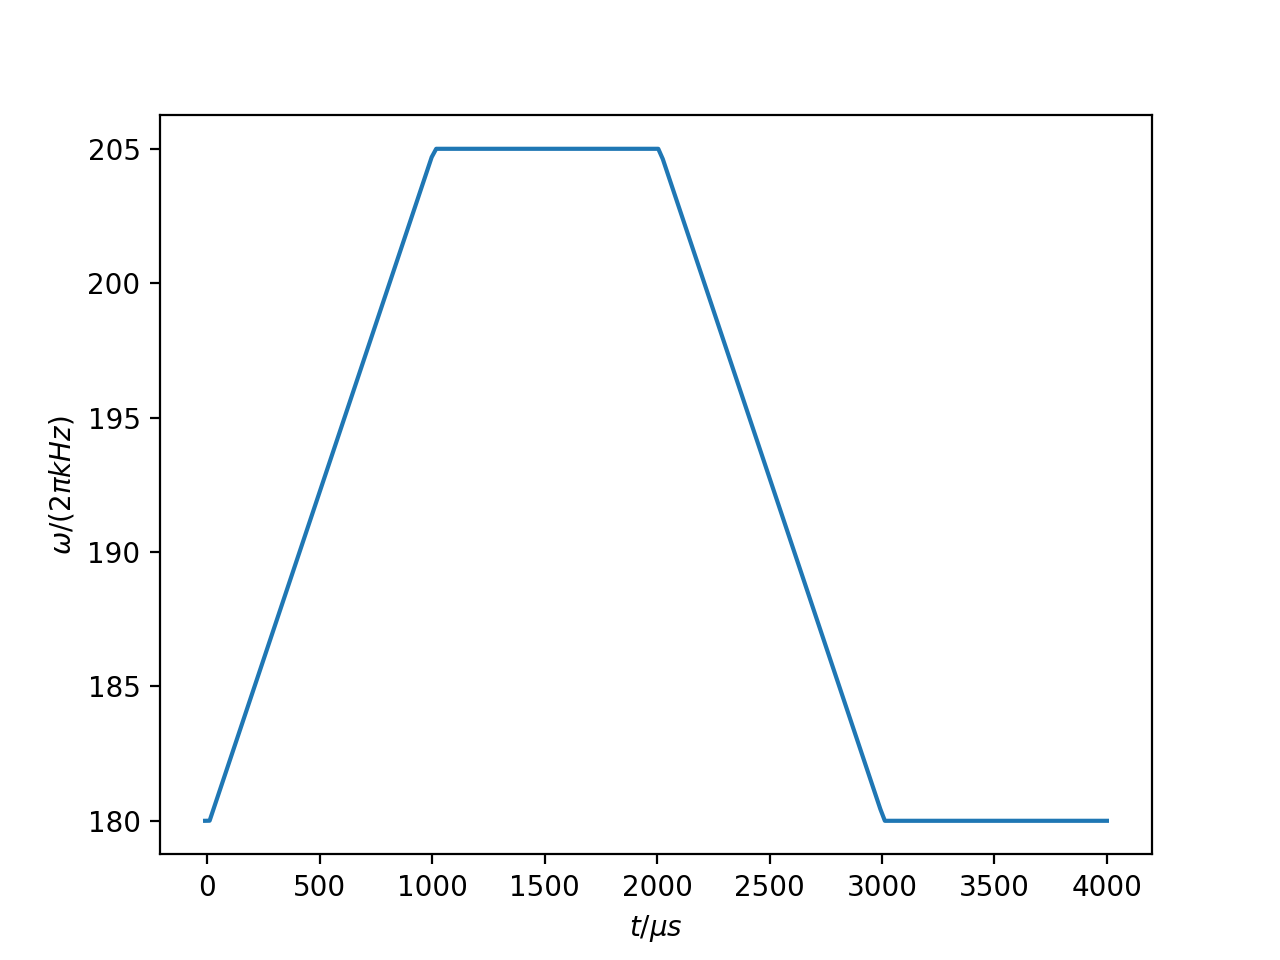

In [101]:
t_max = 4.0e-3
# We start out at 180kHz
omega_0 = 2.0 * np.pi * 180.0e3
# And stay there for a couple of revolutions
t_hold = 1.0e-5
# Then we sweep by 20kHz in 20 revolutions
t_sweep = 1.0e-3
delta_omega = 2.0 * np.pi * 25e3
# Stay at that level for a millisecond, then sweep back
t_hold_2 = 1.0e-3
my_omega_of_t = make_sweep(omega_0, t_hold, t_sweep, delta_omega, t_hold_2)
t = np.linspace(-1.0e-5, t_max, 200)
omega = my_omega_of_t(t)
plt.figure()
plt.plot(t / 1.0e-6, omega / (1.0e3 * 2.0 * np.pi));
plt.xlabel(r'$t/\mu s$')
plt.ylabel(r'$\omega / (2\pi kHz)$');

In [102]:
t_max = 4.0e-3
dt = 1.0e-9

# Definition of the frequency sweep
# We start out at 180kHz
omega_0 = 2.0 * np.pi * 180.0e3
# And stay there for a couple of revolutions
t_hold = 1.0e-5
# Then we sweep by 20kHz in 20 revolutions
t_sweep = 1.0e-3
delta_omega = 2.0 * np.pi * 25e3
# Stay at that level for a millisecond, then sweep back
t_hold_2 = 1.0e-3
my_omega_of_t = make_sweep(omega_0, t_hold, t_sweep, delta_omega, t_hold_2)


kappa_theta = 5.0e6
kappa_z = 1.0e6


my_trap_potential = TrapPotential(2.0 * mode_analysis.Coeff[2],
                                  mode_analysis.Cw,
                                  my_omega_of_t(0.0),
                                  np.pi / 2.0)
my_axial_damping = AxialDamping(kappa=kappa_z)
my_angular_damping = AngularDamping(omega=my_omega_of_t(0.0), kappa_theta=kappa_theta)


# We start out with the steady state distribution with some Gaussian noise in
# the z velocities to seed the multi-plane instability
vz_perturbation = 1.0e-3
my_ensemble = create_ensemble(mode_analysis.uE,
                              my_omega_of_t(0.0),
                              mode_analysis.m_Be,
                              mode_analysis.q)
my_ensemble.v[:, 2] += np.random.normal(loc=0.0, scale=vz_perturbation, size=my_ensemble.num_ptcls)

snap_shot_times = np.linspace(0, t_max, 4000)
snap_shot_times = np.round(snap_shot_times / dt) * dt

snapshots = []
thicknesses = []
t = -dt
while t < t_max:
    # Get the rotation frequency at the mid-point of the time integration interval
    omega = my_omega_of_t(t + 0.5*dt)
    
    # And use it for the rotating wall potential and the angular damping
    my_trap_potential.omega = omega
    my_angular_damping.omega = omega
    
    # Now take a time step
    evolve_ensemble_with_damping(
        dt,
        dt,
        my_ensemble,
        mode_analysis.B,
        [coulomb_force, trap_potential],
        [my_axial_damping, my_angular_damping])
    t += dt
    
    # Record snapshot
    if np.any(np.abs(snap_shot_times - t) < 0.5 * dt):
        snapshots.append((t, omega, my_ensemble.copy()))
    
    # Record thickness of cloud
    thicknesses.append(np.std(my_ensemble.x[:,2]))

t ==  0.0005901480000042465
omega ==  194503.70000010618


<IPython.core.display.Javascript object>


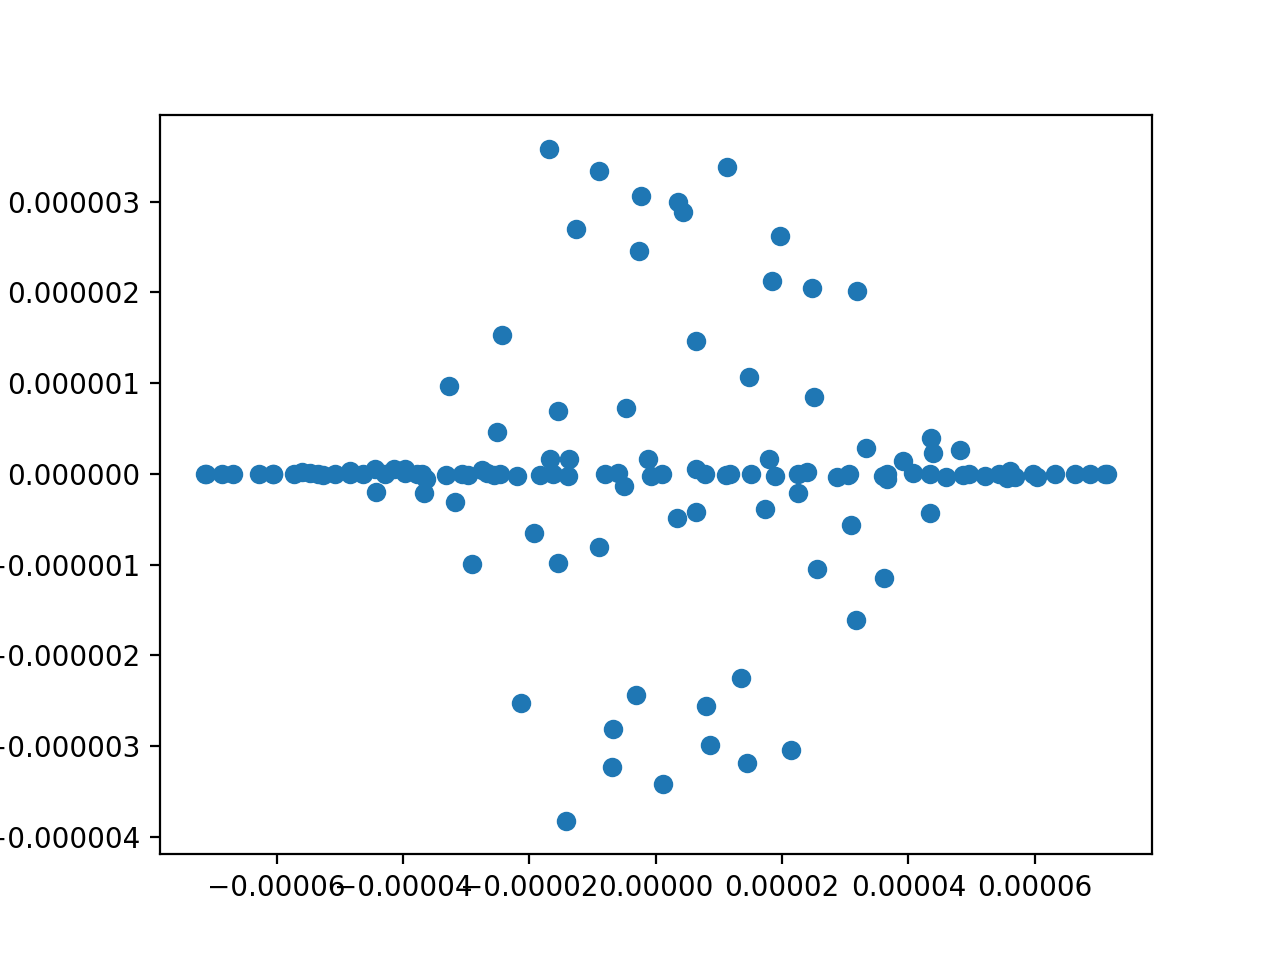

In [109]:
s = snapshots[590]
print('t == ', s[0])
print('omega == ', my_omega_of_t(s[0]) / (2.0 * np.pi))
plt.figure()
plt.plot(s[2].x[:, 0], s[2].x[:, 2], 'o')

t ==  0.0010002500000081355
omega / 2pi ==  204756.2500002034


<IPython.core.display.Javascript object>


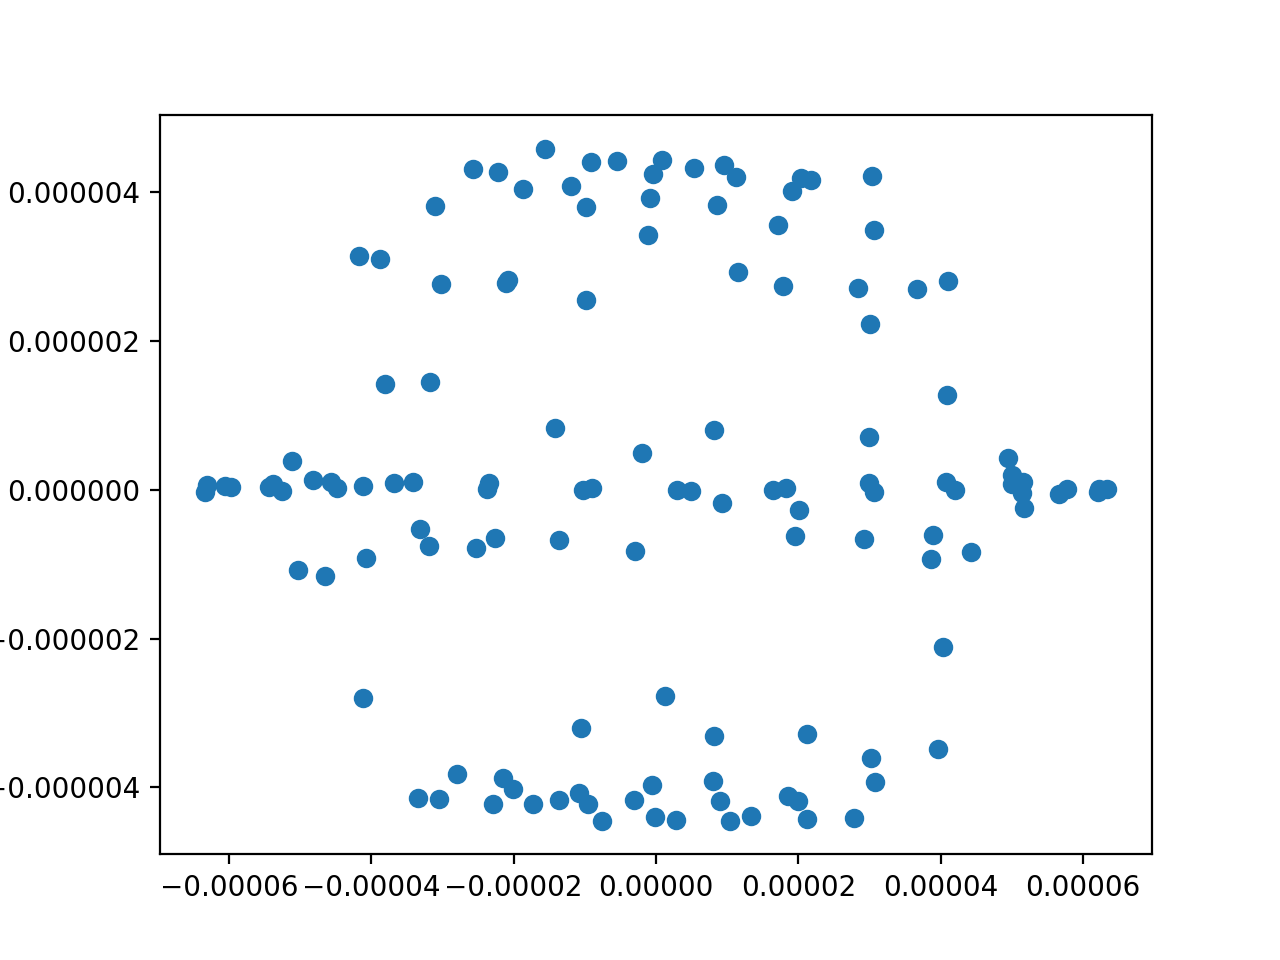

In [117]:
s = snapshots[1000]
print('t == ', s[0])
print('omega / 2pi == ', my_omega_of_t(s[0]) / (2.0 * np.pi))
plt.figure()
plt.plot(s[2].x[:, 0], s[2].x[:, 2], 'o')

In [113]:
ts=np.linspace(0, t_max, len(thicknesses))

<IPython.core.display.Javascript object>


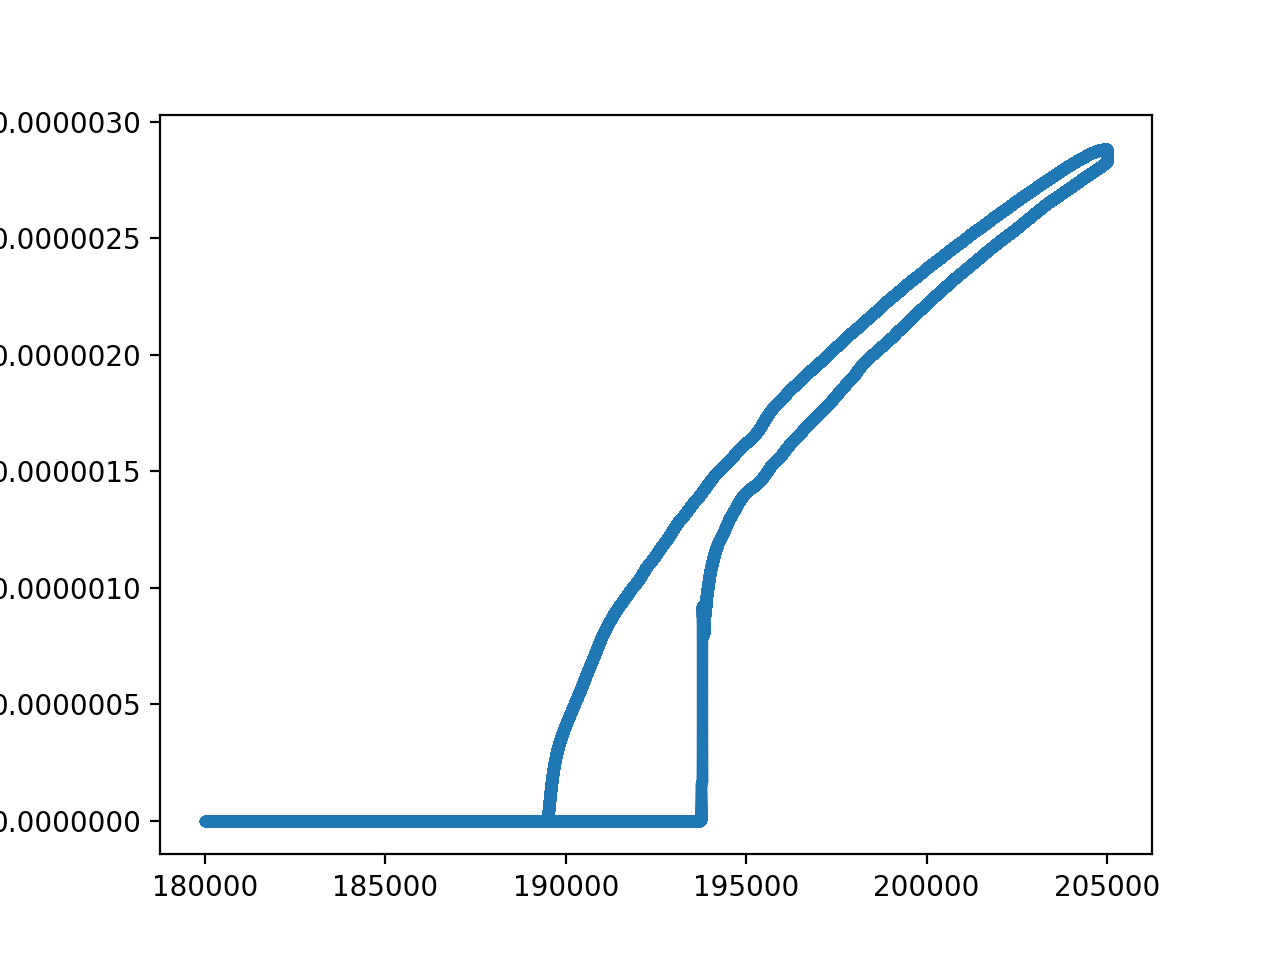

In [115]:
plt.figure()
plt.plot(my_omega_of_t(ts)/(2.0*np.pi),thicknesses,'.')